In [1]:
import pandas as pd
import numpy as np
import sys
import os
import re
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import xgboost as xg

import pickle
import matplotlib.pyplot as plt

import pymorphy2
morph = pymorphy2.MorphAnalyzer()

In [2]:

def save_pickle(a, filepath):
    with open(filepath, 'wb') as handle:
        pickle.dump(a, handle, protocol=pickle.HIGHEST_PROTOCOL)
        
        
def load_pickle(filepath):
    with open(filepath, 'rb') as handle:
        b = pickle.load(handle)
        
    return b

def train_logit_regr(X, y, test_size=0.2, print_auc=True):
    
    lr = LogisticRegression(solver='liblinear')
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=18)
    lr.fit(X_train, y_train)
    pr_train, pr_test = lr.predict_proba(X_train)[:,1], lr.predict_proba(X_test)[:,1]
    if print_auc:
        print(f"auc_train = {roc_auc_score(y_train, pr_train):.2f},\
                auc_test = {roc_auc_score(y_test, pr_test):.2f}")
    return lr

def train_logit_regr_no_split(X, y, print_auc=True):
    
    lr = LogisticRegression(solver='liblinear')
    lr.fit(X, y)
    pr = lr.predict_proba(X)[:,1]
    
    if print_auc:
        print(f"auc = {roc_auc_score(y, pr):.3f}")
        
    return lr

def get_top_n_lr_features(lr, columns, n):
    
    fi = pd.DataFrame({'coef': lr.coef_[0], 'col':columns})
    fi['coef_abs'] = abs(fi['coef'])
    fi = fi.sort_values('coef_abs', ascending=False)
    top_feat = list(fi.iloc[:n]['col'])
    return top_feat

def get_top_n_lr_features_full_table(lr, columns, n):
    
    fi = pd.DataFrame({'coef': lr.coef_[0], 'col':columns})
    fi['coef_abs'] = abs(fi['coef'])
    fi = fi.sort_values('coef_abs', ascending=False)
    
    return fi

def get_column_mapper(df, column, cumsum_border):

    column_df = df.groupby(column).agg({'is_bad' : ['mean', 'size']})
    column_df.columns = ['avg_target_column','column_size']
    column_df = column_df.sort_values('column_size', ascending=False)
    column_df['column_share'] = column_df['column_size'] / len(train)
    column_df['column_cumsum'] = np.cumsum(column_df['column_share'])
    top_column_df = column_df[column_df['column_cumsum'] < cumsum_border]
    top_column = list(top_column_df.index)

    small_column = column_df[column_df['column_cumsum'] >= cumsum_border]
    small_column_avg_target = \
        sum(small_column['column_size'] * small_column['avg_target_column']) / sum(small_column['column_size'])
    small_column_avg_share = small_column.iloc[0]['column_share'] * .8

    column_mapper = top_column_df[['avg_target_column', 'column_share']].reset_index()
    column_mapper.append(['other', small_column_avg_target, small_column_avg_share] )
    column_mapper.loc[len(column_mapper)] =  ['other', small_column_avg_target, small_column_avg_share]
    column_mapper.columns = [f'{column}_filt', f'{column}_avg_target_column', f'{column}_column_share']
    
    return column_mapper

def lemmatize(text):
    return " ".join([morph.parse(word)[0].normal_form for word in text])

def strip_eng(data):
    p = re.compile(r'[a-zA-Z]+')
    return p.sub('', data)

def strip_html(data):
    p = re.compile(r'<.*?>')
    return p.sub(' ', data)

def strip_punctuation(data):
    remove = dict.fromkeys(map(ord, '—«»' + string.punctuation.replace('-', "")), ' ')
    text = data.translate(remove).strip()
    text = text.replace("  ", " ")
    return text

def remove_number(text):
    text = re.sub(r'(0|1|2|3|4|5|6|7|8|9)', '', text)
    return text
  
def remove_stopwords(text, russian_stopwords):
    tokens = [token for token in text.split() if token not in russian_stopwords]
    return ' '.join(tokens)


def handle_emojis(text):
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text)
    return text

def preprocessing_all_method(text,
                            russian_stopwords,
                            numbers=False,
                            stop_words=False,
                            eng=False,
                            leave_only_letters=True ):
    
    text = str(text).strip().lower()

    text = handle_emojis(text)
    text = strip_punctuation(text)

    text = text.replace("\n", " ")
    text = text.replace("-", " ")
    text = text.replace("₽", "")


    if eng:
        text = strip_eng(text)
        
    if numbers:
        text = remove_number(text)
        
    text = text.replace("  ", " ")
    
    if stop_words:
        text = remove_stopwords(text, russian_stopwords)
    
    if leave_only_letters:
        text = re.sub('[^a-zA-Z0-9а-яА-Я]+', ' ', text)
        
    text = re.sub("\s\s+" , " ", text)
    
    return text


In [3]:
with open('dicts/russian_stopwords.txt', 'r') as f:
    stopwords = f.readline()
    stopwords = set(stopwords.split(', '))

In [4]:
with open('dicts/categories_list.txt', 'r') as f:
    categories = [x.strip() for x in f.readlines()]

In [5]:
with open('dicts/top_400_lemmas.txt', 'r') as f:
    top_400_feat_full_tfidf = [x.strip() for x in f.readlines()]

In [6]:
region_mapper = pd.read_csv('dicts/region_mapper.csv')
city_mapper = pd.read_csv('dicts/city_mapper.csv')

avg_target_subcategory = pd.read_csv('dicts/avg_target_subcategory.csv')
avg_target_category    = pd.read_csv('dicts/avg_target_category.csv')

sub_price_medians = pd.read_csv('dicts/sub_price_medians.csv')

In [7]:
train = pd.read_csv('data/prep_train.csv')

In [ ]:
# train['prep_description'] = train['description'].\
#     apply(lambda x: preprocessing_all_method(x, stopwords, eng=False, numbers=True))

In [255]:
# train['lemm_description'] = train['prep_description'].str.split().apply(lemmatize)
# train.to_csv('data/prep_train.csv', index=False)

In [8]:
train['datetime_submitted'] = pd.to_datetime(train['datetime_submitted'])

train['hour_of_day'] = train['datetime_submitted'].dt.hour
train['day_of_week'] = train['datetime_submitted'].dt.day

train['region_filt'] = np.where(train['region'].isin(region_mapper['region_filt']), train['region'], 'other')
train['city_filt'] = np.where(train['city'].isin(city_mapper['city_filt']), train['city'], 'other')

train['subcategory'] = \
    np.where(train['subcategory'].isin(avg_target_subcategory['subcategory']), train['subcategory'], 'other')

train['category'] = \
    np.where(train['category'].isin(avg_target_category['category']), train['category'], 'other')


In [9]:
category_dumm = pd.DataFrame(index=train.index)

for category in categories:
    category_dumm[f'category_{category}_dumm'] = train['category'] == category
    
category_dumm = category_dumm.astype(float)

In [10]:
train['lemm_description'] = train['lemm_description'].fillna('')

In [11]:
tfidf_lemm = load_pickle('models/tfidf.pickle')

tf_features_lemm = tfidf_lemm.transform(train['lemm_description'])

tfidf_df_lemm = pd.DataFrame(
    tf_features_lemm.todense(),
    columns=tfidf_lemm.get_feature_names()
)

top_400_lems_df = tfidf_df_lemm[top_400_feat_full_tfidf]
top_400_lems_df.columns = [f'lemm_{col}' for col in top_400_lems_df]

In [16]:
top_400_lems_df.to_csv('t400df.csv', index=False)

In [12]:
contain_masks = ['9\d{9}[^\d]', '89\d{9}[^\d]', '79\d{9}[^\d]', '\+79\d{9}[^\d]', '\+7', '9\d{2}', '89', '79', '\+79']

train['only_num_descr'] = train['description'].replace('[^0-9\+]', '', regex=True)

phone_mask_features = pd.DataFrame(index = train.index)

for ix, mask in enumerate(contain_masks):
    phone_mask_features[f'cm_{ix}'] = train['description'].str.contains(mask)
    phone_mask_features[f'cm_on_{ix}'] = train['only_num_descr'].str.contains(mask)

phone_mask_features = phone_mask_features.astype(float)

In [14]:
phone_mask_features.to_csv('pmf.csv', index=False)

In [22]:
train_tr = train.copy()

train_tr = train_tr.reset_index().merge(city_mapper).merge(region_mapper)\
    .merge(avg_target_subcategory).merge(avg_target_category).merge(sub_price_medians).set_index('index').sort_index()

train_tr['price'] = train_tr['price'].fillna(train_tr['price_sub_median'])

In [23]:
train_conc = pd.concat([train_tr, category_dumm, phone_mask_features, top_400_lems_df], axis=1)

In [15]:
y = train_conc['is_bad']

In [92]:
drop_columns = ['title', 'description', 'subcategory', 'category','region',
       'city', 'datetime_submitted', 'is_bad', 'prep_description',
       'only_num_descr', 'lemm_description', 'region_filt', 'city_filt', 'avg_target_category', 'region_column_share',
               'city_column_share', 'city_avg_target_column']

train_tr = train_tr.drop(drop_columns, 1)

In [93]:
train_tr.columns

Index(['price', 'hour_of_day', 'day_of_week', 'region_avg_target_column',
       'avg_target_subcategory', 'price_sub_median'],
      dtype='object')

In [95]:
corr = train_tr.corr()
corr

,price,hour_of_day,day_of_week,region_avg_target_column,avg_target_subcategory,price_sub_median
price,1.000000,-0.000714,0.000327,0.004311,0.004021,-0.000224
hour_of_day,-0.000714,1.000000,0.002350,-0.010006,0.004077,-0.001503
day_of_week,0.000327,0.002350,1.000000,0.007289,-0.000521,-0.005890
region_avg_target_column,0.004311,-0.010006,0.007289,1.000000,0.171351,0.107446
avg_target_subcategory,0.004021,0.004077,-0.000521,0.171351,1.000000,0.296447
price_sub_median,-0.000224,-0.001503,-0.005890,0.107446,0.296447,1.000000


In [97]:
ss = StandardScaler()
train_conc_ss = ss.fit_transform(train_conc)

/usr/local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [99]:
# save_pickle(ss, 'models/scaller.pickle')

In [16]:
ss = load_pickle('models/scaller.pickle')

In [100]:
lr_all_feats = train_logit_regr(train_conc_ss, y)

auc_train = 0.95,                auc_test = 0.95


## some lr

In [102]:
train_tr = train.copy()

train_tr = train_tr.reset_index().merge(city_mapper).merge(region_mapper)\
    .merge(avg_target_subcategory).merge(avg_target_category).merge(sub_price_medians).set_index('index').sort_index()
    

train_tr = train_tr.drop('pr', 1)

train_tr['price'] = train_tr['price'].fillna(train_tr['price_sub_median'])

drop_columns = ['title', 'description', 'subcategory', 'region',
       'city', 'datetime_submitted', 'prep_description',
       'only_num_descr', 'lemm_description', 'region_filt', 'city_filt', 'avg_target_category', 'region_column_share',
               'city_column_share', 'city_avg_target_column']

train_tr = train_tr.drop(drop_columns, 1)

train_conc = pd.concat([train_tr, category_dumm, phone_mask_features, top_400_lems_df], axis=1)

In [105]:
cat_aucs_diff_lr = {} 


for cat in train_conc['category'].unique():
    print(f'category - {cat}')
    df_cat = train_conc[train_conc['category']==cat]
    y_cat = df_cat['is_bad']
    X_cat = df_cat.drop(['category', 'is_bad'],1)
    ss_cat = StandardScaler()
    X_ss_cat = ss_cat.fit_transform(X_cat.astype(float))
    lr_cat = train_logit_regr(X_ss_cat, y_cat)
    pr_cat = lr_cat.predict_proba(X_ss_cat)[:,1]
    cat_aucs_diff_lr[cat] = roc_auc_score(y_cat, pr_cat)
    

category - Для дома и дачи
auc_train = 0.93,                auc_test = 0.92
category - Транспорт
auc_train = 0.98,                auc_test = 0.98
category - Услуги
auc_train = 0.94,                auc_test = 0.94
category - Бытовая электроника
auc_train = 0.94,                auc_test = 0.94
category - Хобби и отдых
auc_train = 0.93,                auc_test = 0.93
category - Личные вещи
auc_train = 0.94,                auc_test = 0.94
category - Недвижимость
auc_train = 0.98,                auc_test = 0.97
category - Животные
auc_train = 0.99,                auc_test = 0.98
category - Для бизнеса
auc_train = 0.87,                auc_test = 0.80
category - Работа
auc_train = 0.90,                auc_test = 0.90


In [ ]:
cat_lrs = {}

for cat in train_conc['category'].unique():
    print(f'category - {cat}')
    df_cat = train_conc[train_conc['category']==cat]
    y_cat = df_cat['is_bad']
    X_cat = df_cat.drop(['category', 'is_bad'],1)
    ss_cat = StandardScaler()
    X_ss_cat = ss_cat.fit_transform(X_cat.astype(float))
    lr_cat = train_logit_regr(X_ss_cat, y_cat)
    pr_cat = lr_cat.predict_proba(X_ss_cat)[:,1]
    cat_aucs_diff_lr[cat] = roc_auc_score(y_cat, pr_cat)
    

In [106]:
np.mean(list(cat_aucs_diff_lr.values()))

0.937890051619249

In [109]:
model_columns = list(train_conc.drop(['category', 'is_bad'],1).columns)

In [111]:
save_pickle(model_columns, 'models/model_columns.pickle')

In [24]:
train['prep_description']  = train['prep_description'].fillna('')

In [26]:
train['description']

0         Продаем диван-кровать. Удобный механизм - евро...
1         Кожух рулевой колонки DAF XF 94 (60066004)/\n ...
2         ! Буст аккаунтов с ммр выше 1000ммр не беру ! ...
3         Продам телевизор . Диагональ 450.наличие входа...
4         Открытки-конверты ручной работы/\nВыполнены в ...
5         Размеры шин Hankook Winter i*Pike RS1 W319. Пр...
6         приора 918 норма+кондинционер. 014 машина 16 в...
7         Продам дверь входную, данная дверь стояла от з...
8         Продаю джинсы фирмы Gulliver.   Отличная посадка.
9         Куплены на ASOS, не подошёл размер/\nСоответсв...
10        АВТОСЕРВИС "ВИКИНГ"/\n-ОКРАШИВАНИЕ ЭЛЕМЕНТА от...
11        👍Лучшее предложение в Твери! СКИДКА! Гарантия ...
12        Ворота кованые с калиткой, распашные/\nВысота ...
13        новый купальник Lascana с эффектом Push-up, цв...
14        Продается Радиатор целый на деу нексия н100./\...
15                            Срок до 20.07.2020,не вскрыта
16        С 13 октября сдам двух комнатн

In [76]:
q = train[:10000].copy()

In [77]:
q['l1'] = q['prep_description'].str.split().str.len()
q['l2'] = q['lemm_description'].str.split().str.len()

In [79]:
q[q['l1']!= q['l2']]

,title,description,subcategory,category,price,region,city,datetime_submitted,is_bad,prep_description,only_num_descr,lemm_description,hour_of_day,day_of_week,region_filt,city_filt,pr,l1,l2


In [17]:
ss = StandardScaler()
ss.fit(train_conc[model_columns])

/usr/local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)


StandardScaler(copy=True, with_mean=True, with_std=True)

In [18]:
save_pickle(ss, 'models/scaller.pickle')

In [17]:
model_columns = load_pickle('models/model_columns.pickle')
ss = load_pickle('models/scaller.pickle')

In [18]:
a = ss.transform(train_conc[model_columns])

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:1: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  """Entry point for launching an IPython kernel.


In [21]:
cat_ixs = {}

for category in train_conc['category'].unique():
    filt_ix = train_conc['category']==category    
    cat_ixs[category] = list((train_conc['category'][filt_ix]).index)

In [24]:
cat_lrs = {}

for cat in cat_ixs:
    print(cat)
    X_cat = a[cat_ixs[cat]]
    y_cat = y[cat_ixs[cat]]
    lr_cat = train_logit_regr_no_split(X_cat, y_cat)
    cat_lrs[cat] = lr_cat

Для дома и дачи
auc = 0.930
Транспорт
auc = 0.977
Услуги
auc = 0.937
Бытовая электроника
auc = 0.942
Хобби и отдых
auc = 0.936
Личные вещи
auc = 0.944
Недвижимость
auc = 0.976
Животные
auc = 0.986
Для бизнеса
auc = 0.862
Работа
auc = 0.902


In [25]:
save_pickle(cat_lrs, 'models/cat_lrs.pickle')

In [26]:
lr_all_feats = train_logit_regr_no_split(a, y)

auc = 0.950


In [28]:
save_pickle(lr_all_feats, 'models/lr_all_feats.pickle')

In [19]:
lr_all_feats = load_pickle('models/lr_all_feats.pickle')

In [20]:
pr = lr_all_feats.predict_proba(a)[:,1]

In [21]:
train['pr'] = pr

In [22]:
ch = train[['is_bad', 'pr']].copy()

In [23]:
ch = ch.sort_values('pr', ascending=False).reset_index().rename(columns={'index':'id'})

In [24]:
ch['buck'] = ch.index * 100 // len(ch)

In [29]:
id_for_study = list(ch[(ch['pr'] < 0.024) & (ch['is_bad']==1)]['id'])

In [34]:
sorted(id_for_study)

[3,
 41,
 103,
 161,
 305,
 354,
 411,
 567,
 828,
 857,
 982,
 993,
 1144,
 1185,
 1220,
 1299,
 1325,
 1420,
 1461,
 1548,
 1612,
 1622,
 1646,
 2055,
 2090,
 2136,
 2146,
 2173,
 2227,
 2279,
 2444,
 2470,
 2516,
 2547,
 2560,
 2572,
 2611,
 2657,
 2959,
 2995,
 3008,
 3213,
 3272,
 3348,
 3628,
 3662,
 3706,
 3922,
 4058,
 4074,
 4244,
 5487,
 5656,
 5810,
 5929,
 6007,
 6011,
 6041,
 6139,
 6227,
 6377,
 6434,
 6458,
 6466,
 6491,
 6873,
 7086,
 7107,
 7167,
 7285,
 7421,
 7461,
 7532,
 7741,
 7764,
 7857,
 7996,
 8119,
 8568,
 8784,
 8844,
 8855,
 8973,
 9098,
 9131,
 9332,
 9363,
 9448,
 9464,
 9531,
 9570,
 9618,
 9652,
 9713,
 9794,
 9839,
 9955,
 10057,
 10106,
 10285,
 10351,
 10400,
 10403,
 10436,
 10481,
 10655,
 10734,
 10769,
 10792,
 10804,
 10855,
 10965,
 11118,
 11176,
 11323,
 11370,
 11406,
 11431,
 11436,
 11455,
 11458,
 11461,
 11722,
 11882,
 11888,
 11909,
 11933,
 11972,
 12040,
 12046,
 12051,
 12111,
 12113,
 12168,
 12194,
 12235,
 12249,
 12304,
 12306,


In [37]:
train_study = train.iloc[sorted(id_for_study)]

In [40]:
for d in train_study[:10]['description']:
    print(d, end='\n\n')

Продам телевизор . Диагональ 450.наличие входа USB для подключения накопителей и специализированных многофункциональных устройств;/
/
функция приема сигнала сети Интернет;/
/
возможность останавливать трансляцию ТВ-программ при помощи Time Shift;/
/
технология Quattron, улучшающая цветопередачу экрана;/
/
сканирующая подсветка, не допускающая смазывания кадров;/
/
имеющаяся  функция Skype Ready;/
/
комплектование жидкокристаллическими панелями последнего поколения X-gen;/
/
система Aquos.

Камера основная Samsung galaxy S30+.Оригинал.С новой дэмки./
Возможен выездной ремонт вашего телефона.Выезд на дом или в офис.Цены идивидуальны для каждого клиента.(в зависимости от территориальности)./
Приму ваши телефоны на зап.части Samsung S8,S8+,Note8,S9,S9+,Note9./
Если не отвечаю,пишите на Авито.Я обязательно отвечу./
Работаю с регионами.

Samsung galaxy S40+ Nfc.С демо./
Оригинал./
Возможен выездной ремонт вашего телефона.Выезд на дом или в офис.Цены идивидуальны для каждого клиента.(в зависи

In [85]:
q

,title,description,subcategory,category,price,region,city,datetime_submitted,is_bad,prep_description,only_num_descr,lemm_description,hour_of_day,day_of_week,region_filt,city_filt,pr,l1,l2
0,Диван-кровать,Продаем диван-кровать. Удобный механизм - евро...,Мебель и интерьер,Для дома и дачи,7000.0,Россия,Москва,2019-06-01 00:00:15.180656,0,продаем диван кровать удобный механизм еврокни...,640200,продавать диван кровать удобный механизм еврок...,0,1,Россия,Москва,0.034734,37,37
1,Кожух рулевой колонки Даф хф 91 4509834,Кожух рулевой колонки DAF XF 94 (60066004)/\n ...,Запчасти и аксессуары,Транспорт,2290.0,Россия,Москва,2019-06-01 00:00:44.317933,0,кожух рулевой колонки daf xf артикул в наличии...,9460066004230986226262024,кожух рулевой колонка daf xf артикул в наличие...,0,1,Россия,Москва,0.160464,102,102
2,Дешёвый буст аккаунтов Dota 4,! Буст аккаунтов с ммр выше 1000ммр не беру ! ...,Предложение услуг,Услуги,200.0,Северная Осетия,Владикавказ,2019-06-01 00:00:50.249692,1,буст аккаунтов с ммр выше ммр не беру отвечу с...,100021537401534407,буста аккаунт с ммр выше ммр не брать ответить...,0,1,other,Владикавказ,0.993811,34,34
3,Телевизор sharp.Смарт тв.Интернет,Продам телевизор . Диагональ 450.наличие входа...,Аудио и видео,Бытовая электроника,25000.0,Калининградская область,Советск,2019-06-01 00:00:50.325799,1,продам телевизор диагональ наличие входа usb д...,450,продать телевизор диагональ наличие вход usb д...,0,1,Калининградская область,other,0.015737,51,51
4,Открытка-конверт,Открытки-конверты ручной работы/\nВыполнены в ...,Коллекционирование,Хобби и отдых,150.0,Ставропольский край,Ессентукская,2019-06-01 00:00:56.632655,0,открытки конверты ручной работы выполнены в те...,,открытка конверт ручной работа выполнить в тех...,0,1,Ставропольский край,other,0.010540,8,8
5,Зимние шины Hankook Winter i*Pike RS6 W569,Размеры шин Hankook Winter i*Pike RS1 W319. Пр...,Запчасти и аксессуары,Транспорт,11000.0,Московская область,Железнодорожный,2019-06-01 00:01:03.471366,1,размеры шин hankook winter i pike rs w пробег ...,1319500044000+79456796059,размер шина hankook winter i pike rs w пробег ...,0,1,Московская область,Железнодорожный,0.921039,20,20
6,"LADA Priora, 5046",приора 918 норма+кондинционер. 014 машина 16 в...,Автомобили,Транспорт,340000.0,Чеченская Республика,Грозный,2019-06-01 00:01:13.603386,1,приора норма кондинционер машина в отличном со...,918+0141665,приор норма кондинционер машина в отличный сос...,0,1,Чеченская Республика,Грозный,0.805366,48,48
7,Дверь входная,"Продам дверь входную, данная дверь стояла от з...",Ремонт и строительство,Для дома и дачи,3000.0,Россия,Санкт-Петербург,2019-06-01 00:01:33.818452,0,продам дверь входную данная дверь стояла от за...,48759797206,продать дверь входной дать дверь стоялый от за...,0,1,Россия,Санкт-Петербург,0.037413,24,24
8,Джинсы фирмы Gulliver,Продаю джинсы фирмы Gulliver. Отличная посадка.,Детская одежда и обувь,Личные вещи,500.0,Россия,Москва,2019-06-01 00:01:41.136540,0,продаю джинсы фирмы gulliver отличная посадка,,продавать джинса фирма gulliver отличный посадка,0,1,Россия,Москва,0.013462,6,6
9,Кроссовки nike AIR MAX 570 premium,"Куплены на ASOS, не подошёл размер/\nСоответсв...","Одежда, обувь, аксессуары",Личные вещи,8000.0,Россия,Москва,2019-06-01 00:01:55.506778,0,куплены на asos не подош л размер соответсвенн...,4219,купить на asos не подош литр размер соответсве...,0,1,Россия,Москва,0.017619,14,14


In [ ]:
def lemm_column_finder(row, lemm):
    

In [126]:
model_columns = load_pickle('models/model_columns.pickle')
lr_all_feats = load_pickle('models/lr_all_feats.pickle')

In [171]:
string_[prev_words_lengths:]

'www.dede.ru'

In [159]:
a = ['www', 'ru']
sum(a[:0])

0

In [ ]:
re.sub('\n|\t', ' ', a).split(' ')

In [127]:
get_top_n_lr_features(lr_all_feats, model_columns, 100)

['lemm_ru',
 'lemm_https',
 'lemm_com',
 'cm_on_6',
 'cm_1',
 'lemm_тело',
 'cm_on_5',
 'cm_4',
 'avg_target_subcategory',
 'cm_5',
 'lemm_звонить',
 'lemm_ру',
 'lemm_imei',
 'lemm_телефон',
 'lemm_пожалуйста назвать',
 'lemm_артикул товар',
 'cm_on_8',
 'lemm_артикул пожалуйста',
 'lemm_восемь',
 'cm_2',
 'region_avg_target_column',
 'lemm_vin',
 'lemm_девятьсот',
 'lemm_оригинальный номер',
 'category_Бытовая электроника_dumm',
 'lemm_по номер',
 'lemm_звонить по',
 'lemm_для связь',
 'lemm_обращаться',
 'lemm_девять',
 'category_Работа_dumm',
 'lemm_mp',
 'lemm_фото',
 'lemm_раздел контакт',
 'lemm_рф',
 'lemm_по рф',
 'lemm_опт по',
 'category_Хобби и отдых_dumm',
 'lemm_хх',
 'lemm_кадастровый номер',
 'lemm_peugeot',
 'lemm_oem',
 'lemm_номер производитель',
 'lemm_совместимый',
 'lemm_магазин сервисный',
 'lemm_на сайт',
 'lemm_звонить на',
 'lemm_скидка для',
 'lemm_обращаться по',
 'cm_3',
 'hour_of_day',
 'lemm_по тело',
 'lemm_деталь наличие',
 'lemm_hp',
 'lemm_указанный о

# task with star

find sentences borders
create a list of sen_borders for every desc

change all symbs to spaces
go throw top features sorted by importances
find word from feature
find word position at sentence
return it

In [146]:
a = '.2!2?\n2q'

In [149]:
re.sub('\!|\?|\n', ' ', a)

'.2 2  2q'

In [157]:
re.sub('\n|\t', ' ', a).split(' ')

['.2!2?', '2q']

In [153]:
s = 'asf  sdasdc\nsdca\ts'.split()
s

['asf', 'sdasdc', 'sdca', 's']

In [47]:
fi = get_top_n_lr_features_full_table(lr_all_feats, model_columns, 10)

In [49]:
fi = fi[fi['coef'] > 0]

In [50]:
fi

,coef,col,coef_abs
35,0.824008,lemm_ru,0.824008
36,0.750039,lemm_https,0.750039
34,0.702428,lemm_com,0.702428
29,0.665431,cm_on_6,0.665431
18,0.581923,cm_1,0.581923
37,0.544312,lemm_тело,0.544312
27,0.516725,cm_on_5,0.516725
24,0.491637,cm_4,0.491637
4,0.469974,avg_target_subcategory,0.469974
26,0.454841,cm_5,0.454841


In [ ]:
web_

In [115]:
il = []

for d in train['description']:
    if 'ᒈ' in d:
        il.append(d)

In [124]:
w = train_conc[train_conc['lemm_ru'] > 0]['lemm_description'].iloc[0]
p = train_conc[train_conc['lemm_ru'] > 0]['prep_description'].iloc[0]
d = train_conc[train_conc['lemm_ru'] > 0]['description'].iloc[0]

ix = w.split().index('ru')
init_word = p.split()[ix]

In [145]:
import inspect
lines = inspect.getsource(find_sentence_borders)
print(lines)

NameError: name 'find_sentence_borders' is not defined

In [127]:
find_sentence_borders(d)

[14, 41, 58]

In [126]:
d.lower().find(init_word)

16

In [128]:
d

'HD-ресивер Дом. RU TV и все комплектующие. Новая приставка.'

In [131]:
d[14+2:41]

'RU TV и все комплектующие'

In [322]:
len('8 9 1.5 0 3 6 8 9 0 8')

21

In [329]:
string_ = ';aksjbdc;aksjbdc;aksjdb 8 9 1.5 0 3 6 8 9 0 8s  '
find_iters('8\D9\D\d\D\d', string_)[0][0]

24

In [325]:
string_[0:22]

'8 9 1.5 0 3 6 8 9 0 8'

In [347]:
string_ =  'есть дополнительный номер тел восемь девять сот двадцать один двести сорок тридцать четыре девяносто три.'

[(37, 41)]

In [358]:
acc_masks = ['\+79\d{9}[^\d]', '79\d{9}[^\d]', '89\d{9}[^\d]', '9\d{9}[^\d]',]
begin_masks = ['\+79', '(\D|^)9\d{2}', '\+7', '(\D|^)89','(\D|^)79']
web_contacts_parts = ['ru', 'http', 'com' , '\.ру', '\.рф', 'www']
social_contacts_parts = ['skype', 'telegram', 'скайп', 'vkontakne', 'вконтакте', 'vk', 'tg', 'телеграм', 'телега']

rus_numbers = \
'раз один два три четыре пять шесть семь восемь девять десять двадцать тридцать сорок пятьдесят шестьдесят семьдесят восемьдесят девяносто'
rus_numbers = rus_numbers.split()


def calc_mask_digit_begining(mask):
    
    add_coeff = 0
    if 'D' in mask:
        add_coeff = -1
    
    for symb in mask:
        if symb == '+':
            return -1 + add_coeff
        if symb in '78':
            return 0 + add_coeff
        if symb == '9':
            return 1 + add_coeff
        
    else:
        return 0

    
mask_digit_begining_dict = {}
    
for mask in begin_masks:
    mask_digit_begining_dict[mask] = calc_mask_digit_begining(mask)
 

def check_trans_in(string_part):
    for rus_number in rus_numbers:
        if rus_number in string_part:
            return True
    else:
        return False
 
def transcription_pos_calc(string_):
    rus_transc = find_iters('девят', string_)

    if rus_transc:
        tr_beg = rus_transc[0][0]
        if check_trans_in(string_[tr_beg:tr_beg+100]):
            return max(0, tr_beg - 5), min(tr_beg + 60, len(string_))

    return None


def find_accur_mask(string_):
    
    return [(m.start(0), m.end(0)-2) for m in re.finditer('|'.join(acc_masks), string_)]


def find_iters(mask, string_):
    
    return [(m.start(0), m.end(0)-1) for m in re.finditer(mask, string_)]


def find_digit_indexes(string_):

    return [m.start(0) for m in re.finditer('\d', string_)]


def find_cutting_borders(string_):

    for mask in begin_masks:
        poss = find_iters(mask, string_)

        if poss:
            poss_begin = poss[0][0]
            nine_begin = poss_begin - mask_digit_begining_dict[mask] + 1
            digit_indexes = find_digit_indexes(string_)
            last_digit_index = [ix for ix in digit_indexes if ix >= nine_begin][:10][-1]
            if last_digit_index - poss_begin > 66 or last_digit_index - poss_begin < 8:
                continue
            return (poss_begin, last_digit_index)
    
    th = find_iters('8\D9\D\d\D\d', string_)
    
    if th:
        return th[0][0], th[0][0] + 21
    
    th = find_iters('9\D\d\D\d\D', string_)
    
    if th:
        return th[0][0], th[0][0] + 19
    
    transcriptions_borders = transcription_pos_calc(string_)
    
    if transcriptions_borders:
        return transcriptions_borders
    
    return None
    
def find_phone_borders(string_):
    
    acc_borders = find_accur_mask(string_)
    
    if acc_borders:
        return acc_borders[0]
    
    return find_cutting_borders(string_)


def find_web_borders(string_):
    
    split_words = re.sub('\n|\t', ' ', string_).split(' ')
    cnt_prev_words = 0
    for w_ix, word in enumerate(split_words):
        if re.findall('|'.join(web_contacts_parts), word):
            prev_words_lengths = sum([len(w) for w in split_words[:w_ix]]) + w_ix
            return (prev_words_lengths, prev_words_lengths + len(word))
        
    else:
        return None

def find_social_borders(string_):
    
    for mask in social_contacts_parts:
        if re.findall(mask, string_):
            split_string = string_.split(mask)
            nick_row = split_string[1].split('\n')[0]
            match = re.search('[\dA_Za-z@_!]+' , nick_row)
            if match:
                prev_len = len(split_string[0]) + len(mask)
                return (prev_len + match.start(), prev_len + match.end())
    else:
        return None

    
def check_intersect(b1, b2):
    
    if set(range(b1[0], b1[1])) & set(range(b2[0], b2[1])):
        return True
    else:
        return False
    
def chose_borders_from_two(b1, b2):
    
    if check_intersect(b1, b2):
        return b1
    else:
        return None

    
def find_borders(desc_string):
    
    string_ = desc_string.lower()
    
    phone_borders = find_phone_borders(string_)
    
    if re.findall('|'.join(web_contacts_parts), string_):
        web_borders = find_web_borders(string_)
    else:
        web_borders = None
        
    if re.findall('|'.join(social_contacts_parts), string_):
        social_borders = find_social_borders(string_)
    else:
        social_borders = None
        
    #print(phone_borders, web_borders, social_borders)
        
    cnt_of_match = int(bool(phone_borders)) + int(bool(web_borders)) + int(bool(social_borders))
    
    if cnt_of_match == 0:
        return None
        
    if cnt_of_match == 3:
        return None
    
    if cnt_of_match == 1:
        return phone_borders if phone_borders else web_borders if web_borders else social_borders
    
    if phone_borders:
        return phone_borders
    
    if not phone_borders:
        return chose_borders_from_two(web_borders, social_borders)
    
    return None
        
    

In [361]:
tst_star = train[:10000][['description','is_bad']].copy()

tst_star['borders_'] = tst_star['description'].apply(find_borders)

tst_star['beg'] = tst_star['borders_'].str[0]
tst_star['end'] = tst_star['borders_'].str[1]

In [363]:
tst_star = train[:10000][['description','is_bad']].copy()
tst_star.to_csv('tst_star.csv', index=False)

In [351]:
len('958 норма+кондинционер. 051машина в отличном состоянии как53 снаружи так и снутри денег не желел32')

98

In [354]:
s = """Продуется колеса с дисками штампованными , плюс колпаки , состоянии идеально износ не более 20 процентов ‘снял с ладе Веста .22 тысяч торг.звонить сюда 89159567870 размер р 25 летние"""

In [355]:
find_accur_mask(s)

[(152, 163)]

In [357]:
s[163]

' '

In [360]:
tst_true = tst_star[tst_star['borders_'].notnull()]

for i in range(30,60):
    desc = tst_true.iloc[i]['description']
    bord = tst_true.iloc[i]['borders_']
    cont = desc[bord[0] : bord[1] +1]
    print(f'\n\n!!! {cont} !!!\n')
    print(desc)



!!!  89589802380 !!!

Карова отёл 30 33 раз бычок 2 месЯца подсос остальные вапросы по тел 89589802380


!!!  89896122927 !!!

Ищу работу /
мне 34 скоро 32/
Звонить по 89896122927


!!!  89O1571O8O3 !!!

Кошечеки породы донской сфинкс готовы к переезду от мамы. Родились 63 апреля. Им ещё только полтора месяца, а они уже ходят строго на лоток и кушают все что дадите со своего стола. Одна более игривая другая более ласковая. Очень любят людей, всегда ко всем лезут на ручки. Их папа и мама есть на фото, оба чистой породы донские сфинксы без единого волоска, имеет ветеринарные паспорта со всеми прививками! живут все вместе с нами) звоните или пишите как вам удобнее 89O1571O8O3


!!! -906-109-27-56 !!!

Сдам шикарнейшее вечернее платье для выпускного напрокат, размер 40-45. Все как на фото. Дополнительные вопросы по телефону 8-906-109-27-56


!!! N9800GT/DI/236MBD1/A, nVidia GeForce 98 !!!

Видеокарта Asus EN9800GT/DI/236MBD1/A, nVidia GeForce 9800 GT 400MHz, 236MB GDDR1 624bit, PhysX, Di

In [339]:
a = [len('восемь девятьсот тринадцать ноль девяноста семь сорок пять ноль четыре'),
len('Восемь ,девятьсот девяносто два пять девяток двадцать шесть'),
len('девят шесть один ноль пять три семь тысяч'),
len('восемь девятьсот шестьдесят ноль девяносто три сорок восемьдесят пять.'),
len('8 дивитсот двацат восем 490 нол пят 28'),
len('восемь девять сот двадцать один двести сорок тридцать четыре девяносто три')]

In [341]:
np.mean(a)

58.666666666666664

In [243]:
string_ = 'asd +15asd0368s788 asd мой  й3452 site www.asdas.ru  сфчс'

bd = find_borders(string_)

if bd:
    print(string_[bd[0]:bd[1] + 1])
else:
    print(None)

None (39, 51) None
www.asdas.ru 


In [128]:

find_accur_mask(string_)

[(4, 16)]

In [122]:
string_ = 'my number +79150asd368ada989 sdsad'
mask = '\\+79'

poss = find_iters(mask, string_)
poss_begin = poss[0][0]
digit_begin = mask_digit_begining_dict[mask]
nine_begin = poss_begin - digit_begin + 1
digit_indexes = find_digit_indexes(string_)



In [123]:
string_[poss_begin:last_digit_index+1]


'+79150asd368ada989'

In [116]:
nine_begin = poss_begin - digit_begin + 1

12

In [32]:
pr = lr_all_feats.predict_proba(a)[:,1]

In [33]:
train['pr'] = pr

In [71]:
cat_aucs = {}

for cat in train['category'].unique():
    df_cat = train[train['category']==cat]
    y_cat = df_cat['is_bad']
    pr_cat = df_cat['pr']
    cat_aucs[cat] = roc_auc_score(y_cat, pr_cat)
    

In [76]:
np.mean(list(cat_aucs.values()))

0.9154114903299512

In [54]:
fpr_rf, tpr_rf, _ = roc_curve(y, pr)

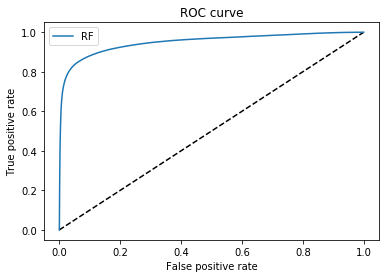

In [57]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

## xgboost

In [60]:
xg_cl = xg.XGBClassifier()

In [61]:
X_train, X_test, y_train, y_test = train_test_split(train_conc_ss, y, test_size=.2, random_state=18)
xg_cl.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1)

In [62]:
pr_xg_train = xg_cl.predict_proba(X_train)[:,1]
pr_xg_test = xg_cl.predict_proba(X_test)[:,1]

In [63]:
roc_auc_score(y_train, pr_xg_train), roc_auc_score(y_test, pr_xg_test)

(0.9467268136267523, 0.9467768762297067)

In [64]:
save_pickle(xg_cl, 'models/xg_cl.pickle')

## top lemmas

In [166]:
samp = train.sample(50000)

lst = []

for txt in samp['prep_description'].str.split():
    
    a = [morph.parse(word)[0].normal_form for word in txt]
    lst.append(a)

tfidf = TfidfVectorizer(ngram_range=(1,2), max_df=.8, min_df=.005)

tf_features = tfidf.fit_transform([' '.join(x) for x in lst])

tfidf_df = pd.DataFrame(
    tf_features.todense(),
    columns=tfidf.get_feature_names()
)

lr = LogisticRegression()
X_train, X_test, y_train, y_test = train_test_split(tfidf_df, samp['is_bad'], test_size=0.2, random_state=42)
lr.fit(X_train, y_train)
pr_train, pr_test = lr.predict_proba(X_train)[:,1], lr.predict_proba(X_test)[:,1]
roc_auc_score(y_train, pr_train), roc_auc_score(y_test, pr_test)

fi = pd.DataFrame({'coef': lr.coef_[0], 'col':tfidf_df.columns})
fi['coef_abs'] = abs(fi['coef'])
fi = fi.sort_values('coef_abs', ascending=False)
top_feat = list(fi.iloc[:200]['col'])

lr2 = LogisticRegression()
X_train, X_test, y_train, y_test = train_test_split(tfidf_df[top_feat], samp['is_bad'], test_size=0.2, random_state=42)
lr2.fit(X_train, y_train)
pr_train, pr_test = lr2.predict_proba(X_train)[:,1], lr2.predict_proba(X_test)[:,1]
roc_auc_score(y_train, pr_train), roc_auc_score(y_test, pr_test)

In [228]:
with open('dicts/top_lemmas.txt', 'w') as f:
    f.write('\n'.join(top_feat))

# full lemas

In [258]:
tfidf = TfidfVectorizer(ngram_range=(1,2), max_df=.8, min_df=.005)

In [259]:
tf_features = tfidf.fit_transform(train['lemm_description'])

In [428]:
mkdir models

In [429]:
save_pickle(tfidf, 'models/tfidf.pickle')

In [436]:
tf_features_lemm_sh = tfidf_lemm.transform(train['lemm_description'].iloc[:10])

In [437]:
tfidf_df_lemm_sh = pd.DataFrame(
    tf_features_lemm_sh.todense(),
    columns=tfidf_lemm.get_feature_names()
)


In [430]:
tfidf_lemm = load_pickle('models/tfidf.pickle')

tf_features_lemm = tfidf_lemm.transform(train['lemm_description'])

tfidf_df_lemm = pd.DataFrame(
    tf_features_lemm.todense(),
    columns=tfidf_lemm.get_feature_names()
)

top_400_lems_df = tfidf_df_lemm[top_400_feat_full_tfidf]
top_400_lems_df.columns = [f'lemm_{col}' for col in top_400_lems_df]

In [271]:
lr_full_tfidf = train_logit_regr(tfidf_df, train['is_bad']) 

auc_train = 0.91,                auc_test = 0.91


In [275]:
for num_top_features in range(100,501,100):
    print(f'num_top_features = {num_top_features}')
    top_feat_full_tfidf = get_top_n_lr_features(lr_full_tfidf, tfidf_df.columns, num_top_features)
    lr_top_n_tfidf = train_logit_regr(tfidf_df[top_feat_full_tfidf], train['is_bad']) 

num_top_features = 100
auc_train = 0.87,                auc_test = 0.87
num_top_features = 200
auc_train = 0.88,                auc_test = 0.88
num_top_features = 300
auc_train = 0.89,                auc_test = 0.89
num_top_features = 400
auc_train = 0.90,                auc_test = 0.90
num_top_features = 500
auc_train = 0.90,                auc_test = 0.90


In [424]:
top_400_feat_full_tfidf = get_top_n_lr_features(lr_full_tfidf, tfidf_df.columns, 400)
# lr_top_400_tfidf = train_logit_regr(tfidf_df[top_feat_full_tfidf], train['is_bad']) 

In [440]:
with open('dicts/top_400_lemmas.txt', 'w') as f:
    f.write('\n'.join(top_400_feat_full_tfidf))



# phone_masks

In [235]:
contain_masks = ['9\d{9}[^\d]', '89\d{9}[^\d]', '79\d{9}[^\d]', '\+79\d{9}[^\d]', '\+7', '9\d{2}', '89', '79', '\+79']

train['only_num_descr'] = train['description'].replace('[^0-9\+]', '', regex=True)

phone_mask_features = pd.DataFrame(index = train.index)

phone_mask_features = pd.DataFrame(index = train.index)

for ix, mask in enumerate(contain_masks):
    phone_mask_features[f'cm_{ix}'] = train['description'].str.contains(mask)
    phone_mask_features[f'cm_on_{ix}'] = train['only_num_descr'].str.contains(mask)

phone_mask_features = phone_mask_features.astype(float)

# categories

In [285]:
len(train[['category', 'subcategory']].drop_duplicates()), len(train['subcategory'].drop_duplicates())

(50, 50)

In [512]:
mean_target = train['is_bad'].mean()

avg_target_subcategory =\
    train.groupby(['subcategory'])['is_bad'].mean().rename('avg_target_subcategory').reset_index()

avg_target_category =\
    train.groupby(['category'])['is_bad'].mean().rename('avg_target_category').reset_index()

avg_target_subcategory.loc[len(avg_target_subcategory)] = ['other', mean_target]
avg_target_category.loc[len(avg_target_category)] = ['other', mean_target]

avg_target_subcategory.to_csv('dicts/avg_target_subcategory.csv', index=False)
avg_target_category.to_csv('dicts/avg_target_category.csv', index=False)

## dummy

In [388]:
categories = train['category'].drop_duplicates().tolist()

In [397]:
with open('dicts/categories_list.txt', 'w') as f:
    f.write('\n'.join(categories))

# city region mappers

In [478]:
city_mapper = get_column_mapper(train, 'city', .85)
region_mapper = get_column_mapper(train, 'region', .9)

In [479]:
city_mapper.to_csv('dicts/city_mapper.csv', index=False)
region_mapper.to_csv('dicts/region_mapper.csv', index=False)

## fillna_price

In [564]:
sub_price_medians = train.groupby('subcategory')['price'].median().rename('price_sub_median').reset_index()

In [565]:
sub_price_medians.loc[len(sub_price_medians)] = ['other', train['price'].median()]

In [566]:
sub_price_medians.to_csv('dicts/sub_price_medians.csv', index=False)

In [384]:
train[:2]

,title,description,subcategory,category,price,region,city,datetime_submitted,is_bad,prep_description,only_num_descr,lemm_description,region_filt,city_filt
0,Диван-кровать,Продаем диван-кровать. Удобный механизм - евро...,Мебель и интерьер,Для дома и дачи,7000.0,Россия,Москва,2019-06-01 00:00:15.180656,0,продаем диван кровать удобный механизм еврокни...,640200,продавать диван кровать удобный механизм еврок...,Россия,Москва
1,Кожух рулевой колонки Даф хф 91 4509834,Кожух рулевой колонки DAF XF 94 (60066004)/\n ...,Запчасти и аксессуары,Транспорт,2290.0,Россия,Москва,2019-06-01 00:00:44.317933,0,кожух рулевой колонки daf xf артикул в наличии...,9460066004230986226262024,кожух рулевой колонка daf xf артикул в наличие...,Россия,Москва


In [98]:
good_examples = train[train['is_bad']==1]['description'][:50]
bad_examples  = train[train['is_bad']==0]['description'][:10]

for i in good_examples:
    print(i, end='\n\n')
   
print('-'*20)

for i in bad_examples:
    print(i, end='\n\n')

! Буст аккаунтов с ммр выше 1000ммр не беру ! /
Отвечу сразу на вопрос: почему здесь?/
2) Я лишь начинаю этим заниматься и других местах большая конкуренция./
Вся связь со мной:/
Vk - vk.com/id153740153/
Discord - Goku#4407

Продам телевизор . Диагональ 450.наличие входа USB для подключения накопителей и специализированных многофункциональных устройств;/
/
функция приема сигнала сети Интернет;/
/
возможность останавливать трансляцию ТВ-программ при помощи Time Shift;/
/
технология Quattron, улучшающая цветопередачу экрана;/
/
сканирующая подсветка, не допускающая смазывания кадров;/
/
имеющаяся  функция Skype Ready;/
/
комплектование жидкокристаллическими панелями последнего поколения X-gen;/
/
система Aquos.

Размеры шин Hankook Winter i*Pike RS1 W319. Пробег шин 5000 км. Все шипы на месте. За комплект 44000 руб. Номер телефона +7 945 679-60-59

приора 918 норма+кондинционер. 014 машина 16 в отличном 65 состоянии как снаружи так и снутри денег не желел нечего делать ненадо как говорит